In [7]:
!pip install records boto3 psycopg2-binary pandas

  Using cached https://files.pythonhosted.org/packages/74/4d/4f16ebe391476e0212b3285454afa82f98a7c2466ecd88f90736c60e22ac/records-0.5.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5f/0b/aa7078d3f6d27d951c38b6a1f4b99b71b2caecebb2921b2d808b5bf0e2e0/psycopg2_binary-2.7.4-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 71kB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 696kB 902kB/s ta 0:00:011
    100% |████████████████████████████████| 174kB 3.0MB/s ta 0:00:01
    100% |████████████████████████████████| 102kB 4.1MB/s a 0:00:011
  Running setup.py bdist_wheel for tablib ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/ea/e4/b9/9eb46eaf91476d5dd88a5cf6f76f0884114eafe0b2ef24e2df
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
  Running setup.py bdist_wheel for odfpy ... done
  Stored i

In [8]:
import boto3
import records
from matplotlib import style
%matplotlib inline
style.use('ggplot')

In [9]:
db_url = boto3.client('ssm').get_parameter(Name='/bikefinder/dev/db_url', WithDecryption=True)['Parameter']['Value']
db = records.Database(db_url)

In [10]:
# number of bikes in operaton per day per provider
bikes_in_service = db.query(
    """
    ( -- number of unique bike_ids per provider (except ofo)
      select created::date, provider, count(distinct bike_id) num_bikes
      from bike_locations
      where provider<>'ofo'
      group by provider, created::date
    )
    union
    ( -- max number of ofo bikes available through out the day
      with ofo as (select * from bike_locations where provider='ofo'),
        counts_per_batch as (select count(bike_id), bike_id, created::date from ofo
                             group by bike_id, created::date)
      select created, 'ofo' provider, max("count") num_bikes
      from counts_per_batch
      group by created
    )
    order by created, provider;
    """).export('df')
bikes_in_service = bikes_in_service.pivot(index='created', columns='provider', values='num_bikes')

In [11]:
bikes_in_service

provider,JUMP,limebike,mobike,ofo,spin
created,,,,,
2018-02-18,54.0,370.0,464.0,338.0,163.0
2018-02-19,57.0,385.0,470.0,337.0,177.0
2018-02-20,68.0,391.0,463.0,330.0,185.0
2018-02-21,75.0,422.0,468.0,295.0,187.0
2018-02-22,190.0,409.0,461.0,350.0,197.0
2018-02-23,123.0,399.0,453.0,343.0,204.0
2018-02-24,69.0,398.0,451.0,323.0,189.0
2018-02-25,72.0,386.0,442.0,312.0,188.0
2018-02-26,84.0,402.0,439.0,337.0,186.0


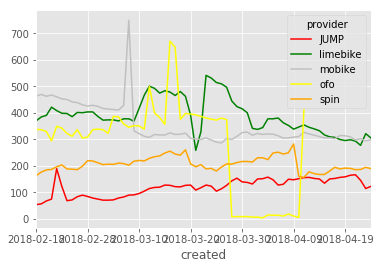

In [12]:
plt = bikes_in_service.plot()
plt.get_lines()[0].set_color('red')
plt.get_legend().get_lines()[0].set_color('red')
plt.get_lines()[1].set_color('green')
plt.get_legend().get_lines()[1].set_color('green')
plt.get_lines()[2].set_color('silver')
plt.get_legend().get_lines()[2].set_color('silver')
plt.get_lines()[3].set_color('yellow')
plt.get_legend().get_lines()[3].set_color('yellow')
plt.get_lines()[4].set_color('orange')
plt.get_legend().get_lines()[4].set_color('orange')

In [13]:
# min,avg,max lifetime of bikes per provider (except ofo, of course)
db.query(
    """
    with bike_lifetimes as (
        select bike_id, provider, max(created) - min(created) age
        from bike_locations
        where provider<>'ofo'
        group by bike_id, provider
    )
    select provider, min(age), avg(age), max(age)
    from bike_lifetimes
    group by provider;
    """).export('df')

,provider,min,avg,max
0,JUMP,0 days,54 days 12:12:19.616412,65 days 01:19:58.904413
1,mobike,0 days,23 days 06:15:29.916406,47 days 02:59:57.831354
2,spin,0 days,31 days 09:38:47.617645,65 days 01:19:58.275543
3,limebike,0 days,24 days 03:12:03.425515,65 days 01:19:57.762256


In [ ]:
db.close()
db._engine.dispose()